In [18]:
# Dependencies
from bs4 import BeautifulSoup
import requests
from splinter import Browser
import pandas as pd
import time
import re
from sqlalchemy import create_engine
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import Column, Integer, String, Float
Base = declarative_base()
import pymysql
pymysql.install_as_MySQLdb()
import numpy as np

# Set path 
import sys
sys.path.append('../')

# Config variables
from config import remote_db_endpoint, remote_db_port
from config import remote_gwsis_dbname, remote_gwsis_dbuser, remote_gwsis_dbpwd
from config import local_gwsis_dbname, local_gwsis_dbuser, local_gwsis_dbpwd 

Create local and remote engines and pass in MySQL connection (you will need to enter your own local information)

In [19]:
# AWS Database Connection
engine = create_engine(f"mysql://{remote_gwsis_dbuser}:{remote_gwsis_dbpwd}@{remote_db_endpoint}:{remote_db_port}/{remote_gwsis_dbname}")

In [20]:
# Create a remote database engine connection
conn = engine.connect()

In [21]:
# Use Splinter to initiate browser
executable_path = {'executable_path': 'chromedriver.exe'}
browser = Browser('chrome', **executable_path, headless=False)

Looking at the following brands/types of birth control
* Shot: Depo-provera
* Hormonal IUD: Mirena
* Non-hormonal IUD: ParaGard (reviews not available)
* Ring: Nuvaring
* Combination pill: Ortho Tri-Cyclen
* Progestin pill: Norethindrone
* Implant: Nexplanon (formerly implanon)
* Patch: Xulane

In [22]:
#These are the birth controls we will look at
types_list = ['depo-provera','mirena','nuvaring','ortho-tri-cyclen','norethindrone','nexplanon','xulane']

Scrape all the reiviews from [Everyday Health](https://www.everydayhealth.com/drugs/) for each of the birth control types. This may take several minutes!

In [23]:
bc_type = []
review_text = []
stars = []
use_case = []
publish_date = []

for t in types_list:
    # URL of page to be scraped
    url = f'https://www.everydayhealth.com/drugs/{t}/reviews'
    browser.visit(url)
    
    html = browser.html
    soup = BeautifulSoup(html, 'html.parser')  

    # Use Splinter to dynamically find the number of pages of reviews
    results = soup.find('div', class_='review-pagination')

    pages = results.text
    max_pages = re.search(r'1 of (.*?) Next', pages).group(1)
    max_pages = int(max_pages)
    i = max_pages + 1
    
    # Use Splinter to click through each page of reviews and scrape the data
    for x in range(1, i):

        html = browser.html
        soup = BeautifulSoup(html, 'html.parser')

        # Retrieve the parent divs for all reviews
        results = soup.find_all('div', class_='review-container')

        # Loop through results to retrieve review details
        for result in results:
            body = result.p.text
            rating = result.find('div', class_="star-rating-print").text[0]
            bc = result.h3.span.text
            date = result.find('span', class_="time")['content']
            my_use = result.h3.text
            my_use_normalized = re.search(r'for (.*?)Report', my_use).group(1)

            bc_type.append(bc)
            review_text.append(body)
            stars.append(rating)
            use_case.append(my_use_normalized)
            publish_date.append(date)    

        try:
            browser.click_link_by_partial_text('Next')

            time.sleep(1)

        except:
            print("Scraping Complete")

Scraping Complete
Scraping Complete
Scraping Complete
Scraping Complete
Scraping Complete
Scraping Complete
Scraping Complete


Check how many reviews we collected, and put them into a DataFrame

In [24]:
len(stars)

2897

In [25]:
bc_df = pd.DataFrame({
    'Birth Control': bc_type,
    'Star Rating': stars,
    'Review': review_text,
    'Use': use_case,
    'Publish Date': publish_date
    })

Use VADER sentiment analysis to analyze the review text for each review. How do women feel about their birth control?

In [26]:
# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [27]:
# Variables for holding sentiments
compound_list = []
positive_list = []
negative_list = []
neutral_list = []

for review in bc_df['Review']:

    # Run Vader Analysis on each review
    results = analyzer.polarity_scores(review)
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]

    # Add each value to the appropriate list
    compound_list.append(compound)
    positive_list.append(pos)
    negative_list.append(neg)
    neutral_list.append(neu)

Store it all in a DataFrame and add original data source and birth control type.

In [32]:
# Store it all in a DataFrame
bc_df = pd.DataFrame({
    'Birth_Control': bc_type,
    'Star_Rating': stars,
    'Review': review_text,
    'Use': use_case,
    'Publish_Date': publish_date,
    'Compound': compound_list,
    'Positive': positive_list,
    'Negative': negative_list,
    'Neutral': neutral_list, 
    'Source' : 'Everyday Health'
    })


In [33]:
# Clean up date
bc_df['Publish_Date'] = [date[:-11] for date in bc_df['Publish_Date']]

In [34]:
# Create a dataframe showing averages for each type of birth control
depo_df = bc_df.loc[bc_df['Birth_Control'] == 'Depo-Provera']
mirena_df = bc_df.loc[bc_df['Birth_Control'] == 'Mirena']
implanon_df = bc_df.loc[bc_df['Birth_Control'] == 'Implanon']
norethindrone_df = bc_df.loc[bc_df['Birth_Control'] == 'Norethindrone']
nuvaring_df = bc_df.loc[bc_df['Birth_Control'] == 'NuvaRing']
xulane_df = bc_df.loc[bc_df['Birth_Control'] == 'Xulane']
combo_df = bc_df.loc[bc_df['Birth_Control'] == 'Ortho Tri-Cyclen']

In [35]:
# Classify each type of birth control
for index, row in bc_df.iterrows():
    if row['Birth_Control'] == 'Depo-Provera':
        bc_df.loc[index,"Method"] = 'Shot'
    elif row['Birth_Control'] == 'Mirena':
        bc_df.loc[index,"Method"] = 'Hormonal IUD'
    elif row['Birth_Control'] == 'Implanon':
        bc_df.loc[index,"Method"] = 'Implant'
    elif row['Birth_Control'] == 'Norethindrone':
        bc_df.loc[index,"Method"] = 'Progestin Pill'
    elif row['Birth_Control'] == 'NuvaRing':
        bc_df.loc[index,"Method"] = 'Ring'
    elif row['Birth_Control'] == 'Xulane':
        bc_df.loc[index,"Method"] = 'Patch'
    elif row['Birth_Control'] == 'Ortho Tri-Cyclen':
        bc_df.loc[index,"Method"] = 'Combination Pill'

In [36]:
bc_df['Star_Rating'] = bc_df['Star_Rating'].astype('int64')
avg_rating = bc_df.groupby('Birth_Control').mean()
avg_rating

,Star_Rating,Compound,Positive,Negative,Neutral
Birth_Control,,,,,
Depo-Provera,2.191257,-0.301481,0.092552,0.141929,0.750486
Implanon,2.611465,-0.154153,0.100624,0.126701,0.753548
Mirena,3.312457,-0.096095,0.103759,0.119281,0.768724
Norethindrone,2.286408,-0.349432,0.075330,0.137549,0.767704
NuvaRing,2.975610,-0.039855,0.103268,0.116976,0.771618
Ortho Tri-Cyclen,3.108696,-0.076774,0.104022,0.111804,0.762424
Xulane,3.238806,-0.013804,0.102843,0.107440,0.759866


In [38]:
# Why is this row misbehaving?
bc_df['Review'][2295]

"I wanted an easy birth control method. Definitely easy to use. Never fell out when it wasn't suppose to, and A LOT LESS acne. The CONS for me was gaining 50lbs, low libido, extra discharge (way extra), feeling like a huge balloon! I've been on it for about a year now and I'm stopping it today! I look like I'm 9 months pregnant no joke! It made my belly balloon out like I have beer gut and I don't drink beer. I feel like my whole body is swollen. The reason I've been on it so long was because I thought it was just me needing to work out more. NOPE! I've been killing myself and no change, still gaining about a pound a week! See ya Nuva Ring! ✌"

In [39]:
# Drop review containing emoji
bc_df_clean = bc_df.drop([2295])

In [42]:
compound_score = []

for score in bc_df['Compound']:
    if score <= 0-.6: 
        compound_score.append('Very Negative')
    elif score <= 0-.2: 
        compound_score.append('Negative')
    elif score <= .2: 
        compound_score.append('Neutral')
    elif score <= .6: 
        compound_score.append('Positive') 
    else:
        compound_score.append('Very Positive')

In [43]:
bc_df['Vader_Scale'] = compound_score

In [44]:
bc_df.head()

,Birth_Control,Star_Rating,Review,Use,Publish_Date,Compound,Positive,Negative,Neutral,Source,Method,Vader_Scale
0,Depo-Provera,1,"After 6 years of taking this injection, my wif...",Birth Control,4/1/2019,-0.5574,0.031,0.075,0.895,Everyday Health,Shot,Negative
1,Depo-Provera,5,Have endrometrisos was bleeding from vagina an...,Endometriosis,3/10/2019,-0.6908,0.051,0.133,0.816,Everyday Health,Shot,Very Negative
2,Depo-Provera,1,I had a miscarriage due to the depo shot. Plea...,Birth Control,3/8/2019,0.0516,0.144,0.109,0.747,Everyday Health,Shot,Neutral
3,Depo-Provera,3,I have been on this for 4/5 years i would reco...,Birth Control,3/6/2019,0.7251,0.212,0.000,0.788,Everyday Health,Shot,Very Positive
4,Depo-Provera,1,"Ive been on it for 2 months now , I get Horrib...",Birth Control,3/5/2019,-0.8772,0.000,0.181,0.819,Everyday Health,Shot,Very Negative


In [47]:
vader_count = pd.DataFrame(bc_df['Vader_Scale'].value_counts())
vader_count

,Vader_Scale
Very Negative,1271
Very Positive,789
Negative,336
Positive,252
Neutral,249


In [65]:
vader_count.to_csv('vader_counts.csv')

In [48]:
method_count = pd.DataFrame(bc_df['Birth_Control'].value_counts())
method_count

,Birth_Control
Mirena,1453
Depo-Provera,732
Norethindrone,206
Implanon,157
Xulane,134
NuvaRing,123
Ortho Tri-Cyclen,92


In [49]:
# What are women using their birth control for?
use_count = pd.DataFrame(bc_df['Use'].value_counts())
use_count

,Use
Birth Control,1691
Contraception,645
Endometriosis,318
Abnormal Uterine Bleeding,97
Depression,32
Premenstrual Syndrome,25
Acne,16
Dysfunctional Uterine Bleeding,12
Migraine,11
Polycystic ovarian syndrome (PCOS),10


In [50]:
# Number of times each rating was given
star_count = pd.DataFrame(bc_df['Star_Rating'].value_counts())
star_count

,Star_Rating
1,973
5,869
4,391
3,324
2,265
0,75


In [51]:
# Create a dataframe showing averages for each type of birth control
bc_df['Star_Rating'] = bc_df['Star_Rating'].astype('int64')
avg_rating = bc_df.groupby('Birth_Control').mean()
avg_rating

,Star_Rating,Compound,Positive,Negative,Neutral
Birth_Control,,,,,
Depo-Provera,2.191257,-0.301481,0.092552,0.141929,0.750486
Implanon,2.611465,-0.154153,0.100624,0.126701,0.753548
Mirena,3.312457,-0.096095,0.103759,0.119281,0.768724
Norethindrone,2.286408,-0.349432,0.075330,0.137549,0.767704
NuvaRing,2.975610,-0.039855,0.103268,0.116976,0.771618
Ortho Tri-Cyclen,3.108696,-0.076774,0.104022,0.111804,0.762424
Xulane,3.238806,-0.013804,0.102843,0.107440,0.759866


In [52]:
# Stats for quantitative feedback (Star Rating)
all_star_avg = bc_df['Star_Rating'].mean()
all_star_variance = np.var(bc_df['Star_Rating'])
all_star_deviation = np.std(bc_df['Star_Rating'])
print(all_star_avg)
print(all_star_variance)
print(all_star_deviation)

2.8940283051432516
2.9915314772796004
1.729604427977565


In [53]:
# Stats for qualitative feedback (Compound VADER score) 
all_compound_avg = bc_df['Compound'].mean()
all_compound_variance = np.var(bc_df['Compound'])
all_compound_deviation = np.std(bc_df['Compound'])
print(all_compound_avg)
print(all_compound_variance)
print(all_compound_deviation)

-0.16234401104590943
0.5498363762922311
0.7415095254224527


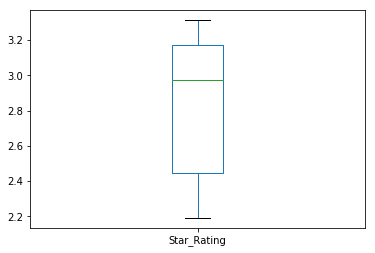

In [55]:
avg_rating['Star_Rating'].plot(kind='box')

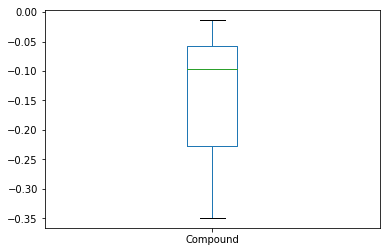

In [56]:
avg_rating['Compound'].plot(kind='box')

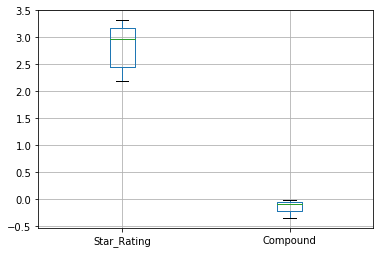

In [57]:
boxplot = avg_rating.boxplot(column=['Star_Rating', 'Compound'])

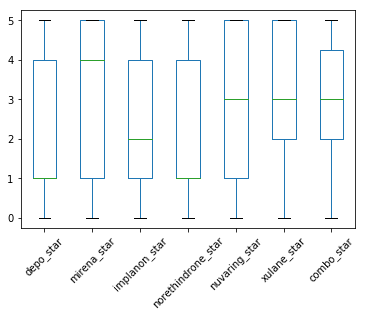

In [58]:
d = {'depo_star' : depo_df['Star_Rating'].astype(int),
'mirena_star' : mirena_df['Star_Rating'].astype(int),
'implanon_star' : implanon_df['Star_Rating'].astype(int),
'norethindrone_star' : norethindrone_df['Star_Rating'].astype(int),
'nuvaring_star' : nuvaring_df['Star_Rating'].astype(int),
'xulane_star' : xulane_df['Star_Rating'].astype(int),
'combo_star' : combo_df['Star_Rating'].astype(int)}


star_comp = pd.DataFrame(data=d)
star_comp.boxplot(rot=45, grid=False, column=['depo_star', 'mirena_star','implanon_star','norethindrone_star','nuvaring_star','xulane_star','combo_star' ])

In [59]:
#List of most common side effects. adding varied language and prurals to capture as many mentions as possible.
side_effects = ['weight','gain','pounds','bloat','bloated','bloating','bleed','bled','bleeding','blood','heavy','spot','spotting','headache',
                'headaches','migraine','migraines','depression','depressed','anxiety','anxious','sad','cry','cried','crying','nausea','nauseous','nauseated',
                'mood','swings','libido','drive','discharge','pain','painful','cramp','cramps','cramping','clot','clots','acne','pimples','breakout','breakouts','zits',
                'infection','vaginosis','vaginitis','bacteria','itchy','itching','dry','dryness','tired','drowsy','drowsiness','fatigue','irritable','irritablility','flashes',
                'hair','cyst','cysts','dizzy','dizziness','vomit','vomitting']

In [ ]:
# Create a funtion to consolidate different words referring to the same side effect
def clean_words(word_set):
    word_set['effects'] = word_set['effects'].replace({'bleed':'bleeding',\
                                                       'bled':'bleeding',\
                                                       'blood':'bleeding', \
                                                       'depressed':'depression', \
                                                       'anxious':'anxiety', \
                                                       'zits':'acne',\
                                                       'pimples':'acne',\
                                                       'breakout':'acne',\
                                                       'breakouts':'acne',\
                                                       'drive':'libido',\
                                                       'pain':'painful',\
                                                       'cramp':'cramps',\
                                                       'cramping':'cramps',\
                                                       'spot':'spotting',\
                                                       'bloat':'bloating',\
                                                       'bloated':'bloating',\
                                                       'cried':'crying',\
                                                       'cry':'crying',\
                                                       'nauseous':'nausea',\
                                                       'nauseated':'nausea',\
                                                       'clot':'clots',
                                                       'headache':'headaches',\
                                                       'migraine':'migraines',\
                                                       'vaginosis':'infection',\
                                                       'vaginitis':'infection',\
                                                       'bacteria':'infection'
                                                      })

In [60]:
bc_df.to_csv('birth_control_site1.csv')

In [ ]:
# Save dataframe to AWS
bc_df.to_sql(name='birth_control_all', if_exists='replace', con=conn, index=False)

In [63]:
# Check remote database to make sure it migrated correctly
remote_bc_data = pd.read_sql("SELECT * FROM birth_control_all", conn)
print(len(remote_bc_data))
remote_bc_data.head()

2897


,Birth_Control,Star_Rating,Review,Use,Publish_Date,Compound,Positive,Negative,Neutral,Source,Method,Vader_Scale
0,Depo-Provera,1,"After 6 years of taking this injection, my wif...",Birth Control,4/1/2019,-0.5574,0.031,0.075,0.895,Everyday Health,Shot,Negative
1,Depo-Provera,5,Have endrometrisos was bleeding from vagina an...,Endometriosis,3/10/2019,-0.6908,0.051,0.133,0.816,Everyday Health,Shot,Very Negative
2,Depo-Provera,1,I had a miscarriage due to the depo shot. Plea...,Birth Control,3/8/2019,0.0516,0.144,0.109,0.747,Everyday Health,Shot,Neutral
3,Depo-Provera,3,I have been on this for 4/5 years i would reco...,Birth Control,3/6/2019,0.7251,0.212,0.000,0.788,Everyday Health,Shot,Very Positive
4,Depo-Provera,1,"Ive been on it for 2 months now , I get Horrib...",Birth Control,3/5/2019,-0.8772,0.000,0.181,0.819,Everyday Health,Shot,Very Negative


In [64]:
# Check that long string was not truncated during transfer
print(remote_bc_data['Review'][1])

Have endrometrisos was bleeding from vagina anus and ureatha heavy clots pain constantly for months ended up with anemia started the injection bleeding has stopped still have odd pelvic pain I'm 42 partner had vascetomy so using only for endrometrisos symptoms and this is first shot and it's been great so far I also have fibroids , was put on provera tablets 20mg few tablets a day for one week prior to starting needle
